# Library Imports / Setup

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
# change current working directory
import os
os.chdir('/content/drive/My Drive/Final Project (NLP)')
os.getcwd()

'/content/drive/My Drive/Final Project (NLP)'

In [0]:
%tensorflow_version 1.x

In [39]:
import numpy as np
import random
import pandas as pd
from ast import literal_eval
import gc
import time
import string
import nltk
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
import seaborn as sns
import tensorflow as tf
print('Tensorflow Version:', tf.__version__)

Tensorflow Version: 1.15.0


In [40]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [41]:
!pip install skll

In [0]:
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Bidirectional, LSTM, Flatten, Input, Dropout
from tensorflow.keras.initializers import Constant
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import cohen_kappa_score
from skll.metrics import kappa
from scipy.stats import spearmanr

In [43]:
# seed for randoom number generator
def seed_everything(SEED):
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    random.seed(SEED)
seed_everything(6000)

AttributeError: ignored

# Data Helper Functions

In [0]:
class Data:
    def __init__(self, df, useStopWord, model, dim, test_size):
        self.df = df
        self.useStopWord = useStopWord
        self.model = model
        self.dim = dim
        self.test_size = test_size

    # returns embeddings matrix to be used for Embedding Layer
    def getEmbeddingMatrix(self, tokenizer_obj):
        word_index_dict = tokenizer_obj.word_index
        vocab_size = len(word_index_dict) + 1
        embedding_matrix = np.zeros((vocab_size, self.dim))
        for word, i in word_index_dict.items():
            embedding_vector = self.model.wv[word]
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
        return embedding_matrix

    # returns main feature vector for all essays - also returns embedding matrix
    def getAllFeatureVec(self, all_essays_tokens):
        tokenizer_obj = Tokenizer()
        tokenizer_obj.fit_on_texts(all_essays_tokens)
        sequences = tokenizer_obj.texts_to_sequences(all_essays_tokens)
        embedding_matrix = self.getEmbeddingMatrix(tokenizer_obj)
        all_feature_vec = np.array(pad_sequences(sequences, maxlen=max([len(seq) for seq in sequences]), padding='post'))
        return all_feature_vec, embedding_matrix

    # returns average feature vector for all essays
    def getAllAvgFeatureVec(self, all_essays_tokens):
        counter = 0
        all_feature_vec = np.zeros((len(all_essays_tokens), self.dim), dtype='float32')
        for essay_tokens in all_essays_tokens:
            average_vec = np.zeros((self.dim,), dtype='float32')
            num_words = 0.
            for word in essay_tokens:
                if word in self.model.wv.vocab:
                    average_vec = np.add(average_vec, self.model.wv[word])
                    num_words += 1.
            if num_words != 0.:
                average_vec = np.divide(average_vec, num_words)
            all_feature_vec[counter] = average_vec
            counter += 1
        return all_feature_vec

    # returns train and test split
    def getTrainTestSplit(self, isTokenizer):
        splits_dict = {}
        if self.useStopWord == True:
            all_essays_tokens = self.df['essay_tokenized_SW']
        else:
            all_essays_tokens = self.df['essay_tokenized_noSW']
        if isTokenizer:
            X, embedding_matrix = self.getAllFeatureVec(all_essays_tokens)
            print('Shape of Embedding Matrix:', embedding_matrix.shape)
        else:
            X = self.getAllAvgFeatureVec(all_essays_tokens)
        Y = self.df['scaled_target_score'].values
        SCORE_INFO = self.df[['essay_set', 'target_score', 'scaled_target_score']]
        train_x, test_x, train_y, test_y, train_score_info, test_score_info = train_test_split(X, Y, SCORE_INFO, test_size=self.test_size, random_state=42)
        print('Shape of TRAIN X:', train_x.shape)
        print('Shape of TEST X: ', test_x.shape)
        print('Shape of TRAIN Y:', train_y.shape)
        print('Shape of TEST Y: ', test_y.shape)
        print('Shape of TRAIN SCORE INFO:', train_score_info.shape)
        print('Shape of TEST SCORE INFO: ', test_score_info.shape)
        splits_dict = {'train_x':train_x, 'test_x':test_x, 
                       'train_y':train_y, 'test_y':test_y, 
                       'train_score_info':train_score_info, 'test_score_info':test_score_info}
        if isTokenizer:
            splits_dict['embedding_matrix'] = embedding_matrix
        return splits_dict

In [0]:
# scales original target scores to specific range based on essay set
def getScaledScores(df, score_range):
    scaled_scores = []
    scaler = MinMaxScaler(feature_range=score_range)
    for topic_number in range(1, 9):
        topic_target_scores = df[df['essay_set'] == topic_number]['target_score'].to_frame()
        scaled_topic_target_scores = (scaler.fit_transform(topic_target_scores).reshape(-1))
        scaled_scores = np.append(scaled_scores, scaled_topic_target_scores)
    return scaled_scores

# Load Main Train Data File

In [46]:
# load cleaned train essay file
df = pd.read_csv('./DATA/clean_train.csv', index_col=False)
# convert string column back to lists type
df[['essay_tokenized_noSW', 'essay_tokenized_SW']] = df[['essay_tokenized_noSW', 'essay_tokenized_SW']].applymap(literal_eval)
# scale target scores to range (0, 1)
df['scaled_target_score'] = getScaledScores(df, score_range=(0, 1))
print('Shape of Dataframe:', df.shape)
df.head(10)

Shape of Dataframe: (12976, 10)


,essay_set,essay,rater1_domain1,rater2_domain1,target_score,essay_clean_noSW,essay_clean_SW,essay_tokenized_noSW,essay_tokenized_SW,scaled_target_score
0,1,"Dear local newspaper, I think effects computer...",4,4,8,"dear local newspaper, think effects computers ...","dear local newspaper, i think effects computer...","[dear, local, newspaper, think, effects, compu...","[dear, local, newspaper, i, think, effects, co...",0.6
1,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5,4,9,"dear label_caps label_caps, believe using comp...","dear label_caps label_caps, i believe that usi...","[dear, labelcaps, labelcaps, believe, using, c...","[dear, labelcaps, labelcaps, i, believe, that,...",0.7
2,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4,3,7,"dear, label_caps label_caps label_caps people ...","dear, label_caps label_caps label_caps more an...","[dear, labelcaps, labelcaps, labelcaps, people...","[dear, labelcaps, labelcaps, labelcaps, more, ...",0.5
3,1,"Dear Local Newspaper, @CAPS1 I have found that...",5,5,10,"dear local newspaper, label_caps found many ex...","dear local newspaper, label_caps i have found ...","[dear, local, newspaper, labelcaps, found, man...","[dear, local, newspaper, labelcaps, i, have, f...",0.8
4,1,"Dear @LOCATION1, I know having computers has a...",4,4,8,"dear label_location, know computers positive e...","dear label_location, i know having computers h...","[dear, labellocation, know, computers, positiv...","[dear, labellocation, i, know, having, compute...",0.6
5,1,"Dear @LOCATION1, I think that computers have a...",4,4,8,"dear label_location, think computers negative ...","dear label_location, i think that computers ha...","[dear, labellocation, think, computers, negati...","[dear, labellocation, i, think, that, computer...",0.6
6,1,Did you know that more and more people these d...,5,5,10,"know people days depending computers safety, n...",did you know that more and more people these d...,"[know, people, days, depending, computers, saf...","[did, you, know, that, more, and, more, people...",0.8
7,1,@PERCENT1 of people agree that computers make ...,5,5,10,label_percent people agree computers make life...,label_percent of people agree that computers m...,"[labelpercent, people, agree, computers, make,...","[labelpercent, of, people, agree, that, comput...",0.8
8,1,"Dear reader, @ORGANIZATION1 has had a dramatic...",4,5,9,"dear reader, label_organization dramatic effec...","dear reader, label_organization has had a dram...","[dear, reader, labelorganization, dramatic, ef...","[dear, reader, labelorganization, has, had, a,...",0.7
9,1,In the @LOCATION1 we have the technology of a ...,5,4,9,label_location technology computer. say comput...,in the label_location we have the technology o...,"[labellocation, technology, computer, say, com...","[in, the, labellocation, we, have, the, techno...",0.7


# Model Functions

In [0]:
# returns fitted model along with history object
def fitModel(model, data, batch_size, epochs, val_size, verbose, callbacks_list, isPlot):
    start = time.time()
    history = model.fit(data['train_x'], data['train_y'], batch_size=batch_size, epochs=epochs, 
                        validation_split=val_size, verbose=verbose, callbacks=callbacks_list)
    end = time.time() - start
    print('\n\tTotal Training Time:', np.round(end, 2), 'seconds')
    print('Train Loss:', np.round(np.mean(history.history['loss']), 4))
    print('Val   Loss:', np.round(np.mean(history.history['val_loss']), 4))
    if isPlot == True:
        plt.figure(figsize=(10, 5))
        plt.plot(history.history['loss'], 'r--', label='train_loss')
        plt.plot(history.history['val_loss'], 'b-', label='val_loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Loss Learning Curve')
        plt.legend(loc='best')
        plt.show()
    return history, model

In [0]:
def calculate_kappa_score(results_df):
    kappa_list = []
    for topic_number in range(1, 8):
        kappa_list.append(kappa(results_df[results_df.essay_set == topic_number]['target_score'], 
                                results_df[results_df.essay_set == topic_number]['rescaled_y_pred'], 
                                weights='quadratic'))
    print('Kappa List:', np.round(kappa_list, 4))
    return np.mean(kappa_list)

In [0]:
def scalePred(results_df):
    score_range_df = results_df.groupby('essay_set')['target_score'].agg(['min', 'max'])
    score_ranges = list(zip(score_range_df['min'], score_range_df['max']))
    rescaled_y_pred_arr = []
    for topic_number in range(1, 9):
        scaler = MinMaxScaler(score_ranges[topic_number - 1])
        rescaled_y_pred = scaler.fit_transform(results_df[results_df['essay_set'] == topic_number]['y_pred'].to_frame()).round(0).astype('int')
        rescaled_y_pred_arr = np.append(rescaled_y_pred_arr, rescaled_y_pred)
    results_df['rescaled_y_pred'] = rescaled_y_pred_arr
    return results_df

In [0]:
def evaluateModel(model, data):
    print('Test Loss:', np.round(model.evaluate(data['test_x'], data['test_y'], verbose=0), 4))
    y_pred = pd.DataFrame(model.predict(data['test_x']).reshape(-1))
    results = data['test_score_info'].reset_index(drop=True).join(y_pred).rename(columns={0:'y_pred'}).sort_values(by='essay_set').reset_index(drop=True)
    results = scalePred(results)
    print('Test Quadratic Cohen Kappa Score:', np.round(calculate_kappa_score(results), 4))
    return results

# LSTM - Single Hidden Layer - Parameter Tuning

In [61]:
# summary of model
BiLSTM(input_shape=(100, 1), drate=0.0).summary()

Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_92 (LSTM)               (None, 100, 128)          66560     
_________________________________________________________________
lstm_93 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dropout_41 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_48 (Dense)             (None, 1)                 65        
Total params: 116,033
Trainable params: 116,033
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_92 (LSTM)               (None, 100, 128)          66560     
________________________

## Cross-Validation Parameter Tuning

In [0]:
#fake bilstm
def LSTM(input_shape,drate):
    """Define the model."""
    model = Sequential()
    model.add(LSTM(128, dropout=drate, recurrent_dropout=0.2, input_shape=input_shape, return_sequences=True,activation='relu', kernel_initializer='he_normal'))
    model.add(LSTM(64, recurrent_dropout=0.2))
    model.add(Dropout(drate))
    model.add(Dense(1, activation='relu'))

    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae'])
    model.summary()

    return model

In [0]:
# performs cross validation training for better model parameter tuning
def cross_val_eval(dim, units, drate, batch_size, epochs, val_size, verbose, callbacks_list, isPlot):
    # get word_model and data for given dimension
    word_model = Word2Vec.load('./DATA/custom_word2vec_models/' + str(dim) + '_noSW_word2vec_model')
    data = Data(df=df, useStopWord=False, model=word_model, dim=dim, test_size=0.1).getTrainTestSplit(isTokenizer=False)
    # reshape input to shape (batch_size, sequence length for one timestep, number of timesteps) -- (1000, 300, 1)
    data['train_x'] = np.reshape(data['train_x'], (data['train_x'].shape[0], 1, data['train_x'].shape[1]))
    data['test_x'] = np.reshape(data['test_x'], (data['test_x'].shape[0], 1, data['test_x'].shape[1]))
    # combine train and test data into one big array/dataframe
    X = np.concatenate([data['train_x'], data['test_x']])
    Y = np.concatenate([data['train_y'], data['test_y']])
    SCORE_INFO = pd.concat([data['train_score_info'], data['test_score_info']], axis=0)
    print('New X Shape:', X.shape)
    print('New Y Shape:', Y.shape)
    print('New SCORE INFO Shape:', SCORE_INFO.shape)
    # split data into 5 folds
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    count = 0
    train_loss = []
    val_loss = []
    test_loss = []
    kappa_list_per_topic = []
    kappa_list_all_topic = []
    for train_index, test_index in kf.split(X):
        count += 1
        print('\n\t\t\t -------- Fold {} --------'.format(count))
        train_x, test_x = X[train_index, :, :], X[test_index, :, :]
        train_y, test_y = Y[train_index], Y[test_index]
        train_score_info, test_score_info = SCORE_INFO.iloc[train_index], SCORE_INFO.iloc[test_index]
        # build model
        model = LSTM(input_shape=(1, dim), drate=drate)
        # fit model
        start = time.time()
        history = model.fit(train_x, train_y, batch_size=batch_size, epochs=epochs, 
                            validation_split=val_size, verbose=verbose, callbacks=callbacks_list)
        end = time.time() - start
        print('Total Training Time:', np.round(end, 2), 'seconds')
        print('Train Loss:', np.round(np.mean(history.history['loss']), 4))
        print('Val   Loss:', np.round(np.mean(history.history['val_loss']), 4))
        train_loss.append(np.mean(history.history['loss']))
        val_loss.append(np.mean(history.history['val_loss']))
        if isPlot == True:
            plt.figure(figsize=(10, 5))
            plt.plot(history.history['loss'], 'r--', label='train_loss')
            plt.plot(history.history['val_loss'], 'b-', label='val_loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.title('Loss Learning Curve')
            plt.legend(loc='best')
            plt.show()
        # evaluate model
        tst_loss = model.evaluate(test_x, test_y, verbose=0)
        print('Test  Loss:', np.round(tst_loss, 4))
        test_loss.append(tst_loss)
        y_pred = pd.DataFrame(model.predict(test_x).reshape(-1))
        results = test_score_info.reset_index(drop=True).join(y_pred).rename(columns={0:'y_pred'}).sort_values(by='essay_set').reset_index(drop=True)
        results = scalePred(results)
        per_topic_kappa_score = calculate_kappa_score(results)
        print('Test Quadratic Cohen Kappa Score (per essay set):', np.round(per_topic_kappa_score, 4))
        all_topic_kappa_score = kappa(results['target_score'], results['rescaled_y_pred'], weights='quadratic')
        print('Test Quadratic Cohen Kappa Score (all essay set):', np.round(all_topic_kappa_score, 4))
        kappa_list_per_topic.append(per_topic_kappa_score)
        kappa_list_all_topic.append(all_topic_kappa_score)
    print('\n\n\t\t\tAverage Results:')
    print('Train Loss:', np.round(np.mean(train_loss), 4))
    print('Val   Loss:', np.round(np.mean(val_loss), 4))
    print('Test  Loss:', np.round(np.mean(test_loss), 4))
    print('QCK Score (per essay set):', np.round(np.mean(kappa_list_per_topic), 4))
    print('QCK Score (all essay set):', np.round(np.mean(kappa_list_all_topic), 4))

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Shape of TRAIN X: (11678, 100)
Shape of TEST X:  (1298, 100)
Shape of TRAIN Y: (11678,)
Shape of TEST Y:  (1298,)
Shape of TRAIN SCORE INFO: (11678, 3)
Shape of TEST SCORE INFO:  (1298, 3)
New X Shape: (12976, 1, 100)
New Y Shape: (12976,)
New SCORE INFO Shape: (12976, 3)

			 -------- Fold 1 --------
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 300)            481200    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
To

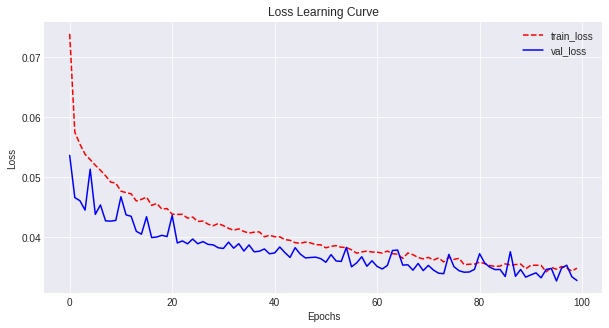

Test  Loss: [0.0334 0.1429]
Kappa List: [0.3606 0.3809 0.4442 0.6157 0.5638 0.701  0.4427 0.2212]
Test Quadratic Cohen Kappa Score (per essay set): 0.4663
Test Quadratic Cohen Kappa Score (all essay set): 0.9588

			 -------- Fold 2 --------
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 1, 300)            481200    
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 574,705
Trainable params: 574,705
Non-trainable params: 0
_________________________________________________________________
Tota

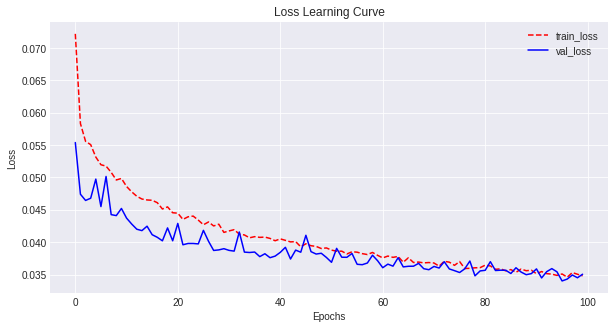

Test  Loss: [0.0325 0.1411]
Kappa List: [0.4245 0.4631 0.4161 0.6059 0.487  0.6103 0.503  0.1791]
Test Quadratic Cohen Kappa Score (per essay set): 0.4611
Test Quadratic Cohen Kappa Score (all essay set): 0.9468

			 -------- Fold 3 --------
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 1, 300)            481200    
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 574,705
Trainable params: 574,705
Non-trainable params: 0
_________________________________________________________________
Tota

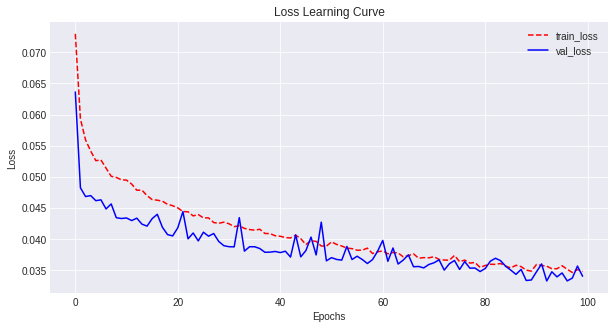

Test  Loss: [0.032  0.1397]
Kappa List: [0.5519 0.4698 0.507  0.6384 0.5563 0.659  0.3616 0.305 ]
Test Quadratic Cohen Kappa Score (per essay set): 0.5061
Test Quadratic Cohen Kappa Score (all essay set): 0.9499

			 -------- Fold 4 --------
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 1, 300)            481200    
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 574,705
Trainable params: 574,705
Non-trainable params: 0
_________________________________________________________________
Tota

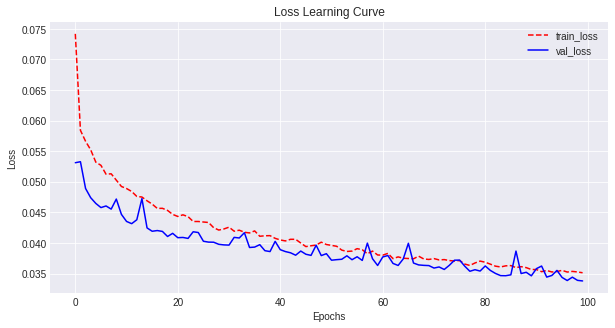

Test  Loss: [0.0308 0.1377]
Kappa List: [0.6214 0.378  0.4172 0.6587 0.486  0.706  0.5847 0.1738]
Test Quadratic Cohen Kappa Score (per essay set): 0.5032
Test Quadratic Cohen Kappa Score (all essay set): 0.9573

			 -------- Fold 5 --------
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 1, 300)            481200    
_________________________________________________________________
lstm_9 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 574,705
Trainable params: 574,705
Non-trainable params: 0
_________________________________________________________________
Tota

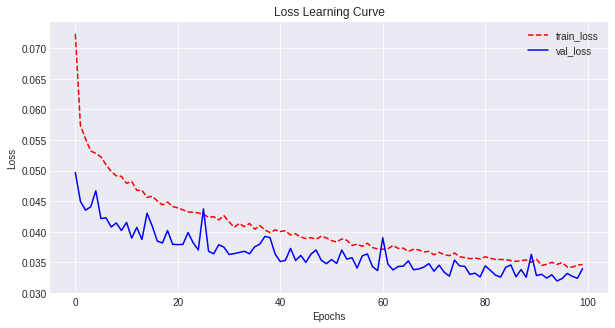

Test  Loss: [0.0354 0.1472]
Kappa List: [0.4664 0.4316 0.375  0.5454 0.4229 0.589  0.3145 0.3055]
Test Quadratic Cohen Kappa Score (per essay set): 0.4313
Test Quadratic Cohen Kappa Score (all essay set): 0.9579


			Average Results:
Train Loss: 0.0408
Val   Loss: 0.0382
Test  Loss: 0.0873
QCK Score (per essay set): 0.4736
QCK Score (all essay set): 0.9542


In [26]:
cross_val_eval(dim=100, units=64, drate=0.4, batch_size=128, epochs=100, val_size=0.1, verbose=0, callbacks_list=None, isPlot=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Shape of TRAIN X: (11678, 300)
Shape of TEST X:  (1298, 300)
Shape of TRAIN Y: (11678,)
Shape of TEST Y:  (1298,)
Shape of TRAIN SCORE INFO: (11678, 3)
Shape of TEST SCORE INFO:  (1298, 3)
New X Shape: (12976, 1, 300)
New Y Shape: (12976,)
New SCORE INFO Shape: (12976, 3)

			 -------- Fold 1 --------
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 1, 300)            721200    
_________________________________________________________________
lstm_11 (LSTM)               (None, 64)                93440     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 814,705
Trainable params: 814,705
Non-trainable params: 0
_________

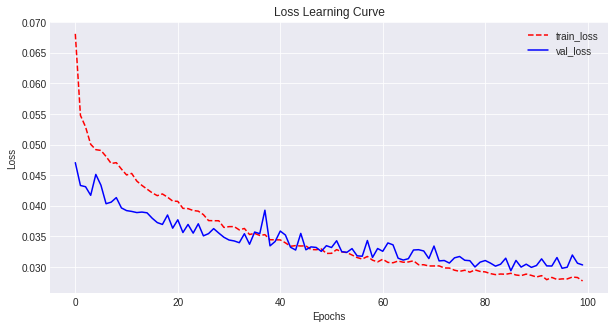

Test  Loss: [0.0298 0.1338]
Kappa List: [0.5673 0.2517 0.4492 0.6531 0.6079 0.7462 0.6066 0.2955]
Test Quadratic Cohen Kappa Score (per essay set): 0.5222
Test Quadratic Cohen Kappa Score (all essay set): 0.9657

			 -------- Fold 2 --------
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 1, 300)            721200    
_________________________________________________________________
lstm_13 (LSTM)               (None, 64)                93440     
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 814,705
Trainable params: 814,705
Non-trainable params: 0
_________________________________________________________________
Tota

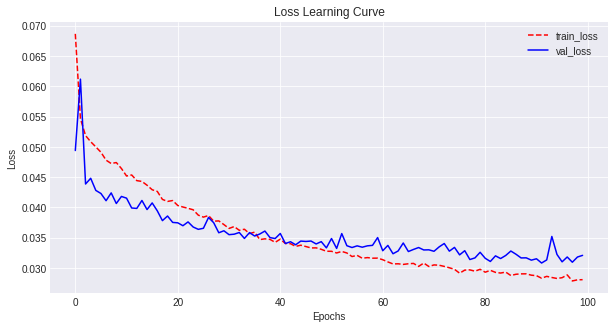

Test  Loss: [0.0283 0.1305]
Kappa List: [0.5134 0.5118 0.4552 0.6802 0.6602 0.659  0.6475 0.3556]
Test Quadratic Cohen Kappa Score (per essay set): 0.5604
Test Quadratic Cohen Kappa Score (all essay set): 0.9676

			 -------- Fold 3 --------
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 1, 300)            721200    
_________________________________________________________________
lstm_15 (LSTM)               (None, 64)                93440     
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 814,705
Trainable params: 814,705
Non-trainable params: 0
_________________________________________________________________
Tota

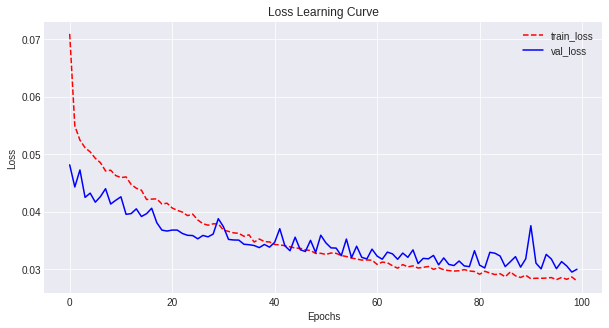

Test  Loss: [0.0272 0.1291]
Kappa List: [0.5802 0.4769 0.5119 0.7177 0.5905 0.7252 0.4972 0.2433]
Test Quadratic Cohen Kappa Score (per essay set): 0.5429
Test Quadratic Cohen Kappa Score (all essay set): 0.9538

			 -------- Fold 4 --------
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 1, 300)            721200    
_________________________________________________________________
lstm_17 (LSTM)               (None, 64)                93440     
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 814,705
Trainable params: 814,705
Non-trainable params: 0
_________________________________________________________________
Tota

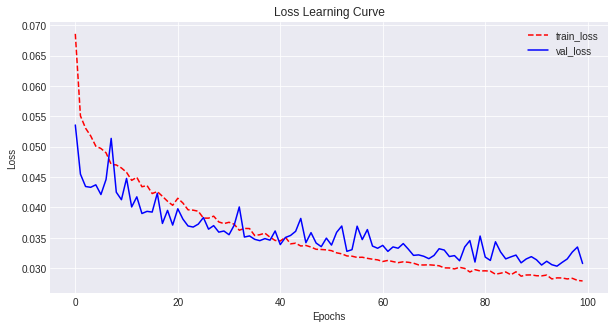

Test  Loss: [0.0272 0.1284]
Kappa List: [0.4789 0.4948 0.4972 0.7408 0.5533 0.7397 0.6436 0.3561]
Test Quadratic Cohen Kappa Score (per essay set): 0.563
Test Quadratic Cohen Kappa Score (all essay set): 0.9719

			 -------- Fold 5 --------
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 1, 300)            721200    
_________________________________________________________________
lstm_19 (LSTM)               (None, 64)                93440     
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 814,705
Trainable params: 814,705
Non-trainable params: 0
_________________________________________________________________
Total

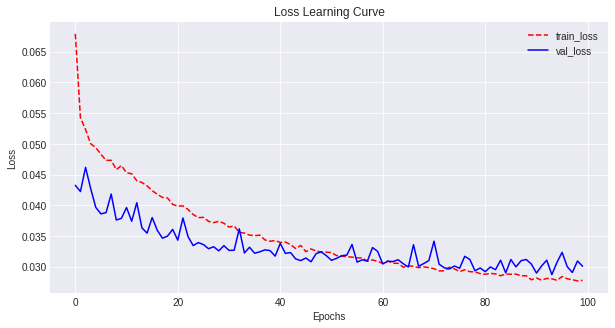

Test  Loss: [0.0306 0.1365]
Kappa List: [0.5188 0.4218 0.463  0.6338 0.5593 0.6808 0.629  0.2784]
Test Quadratic Cohen Kappa Score (per essay set): 0.5231
Test Quadratic Cohen Kappa Score (all essay set): 0.968


			Average Results:
Train Loss: 0.0352
Val   Loss: 0.0347
Test  Loss: 0.0801
QCK Score (per essay set): 0.5423
QCK Score (all essay set): 0.9654


In [27]:
cross_val_eval(dim=300, units=64, drate=0.4, batch_size=128, epochs=100, val_size=0.1, verbose=0, callbacks_list=None, isPlot=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Shape of TRAIN X: (11678, 300)
Shape of TEST X:  (1298, 300)
Shape of TRAIN Y: (11678,)
Shape of TEST Y:  (1298,)
Shape of TRAIN SCORE INFO: (11678, 3)
Shape of TEST SCORE INFO:  (1298, 3)
New X Shape: (12976, 1, 300)
New Y Shape: (12976,)
New SCORE INFO Shape: (12976, 3)

			 -------- Fold 1 --------
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_50 (LSTM)               (None, 1, 300)            721200    
_________________________________________________________________
lstm_51 (LSTM)               (None, 64)                93440     
_________________________________________________________________
dropout_25 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 65        
Total params: 814,705
Trainable params: 814,705
Non-trainable params: 0
________

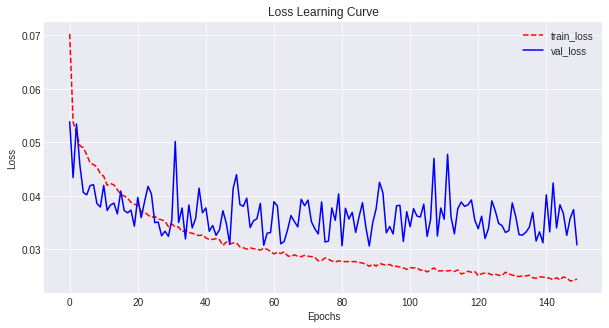

Test  Loss: [0.0306 0.1353]
Kappa List: [0.5217 0.3004 0.4997 0.6916 0.6351 0.7577 0.6848]
Test Quadratic Cohen Kappa Score (per essay set): 0.5844
Test Quadratic Cohen Kappa Score (all essay set): 0.9626

			 -------- Fold 2 --------
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_52 (LSTM)               (None, 1, 300)            721200    
_________________________________________________________________
lstm_53 (LSTM)               (None, 64)                93440     
_________________________________________________________________
dropout_26 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 65        
Total params: 814,705
Trainable params: 814,705
Non-trainable params: 0
_________________________________________________________________
Total Trai

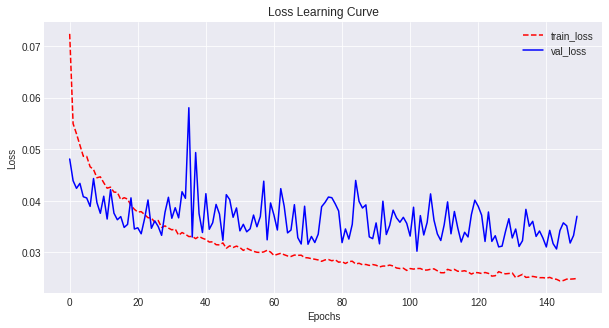

Test  Loss: [0.0341 0.1445]
Kappa List: [0.5038 0.5058 0.5563 0.6574 0.6951 0.6741 0.6769]
Test Quadratic Cohen Kappa Score (per essay set): 0.6099
Test Quadratic Cohen Kappa Score (all essay set): 0.9676

			 -------- Fold 3 --------
Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_54 (LSTM)               (None, 1, 300)            721200    
_________________________________________________________________
lstm_55 (LSTM)               (None, 64)                93440     
_________________________________________________________________
dropout_27 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 65        
Total params: 814,705
Trainable params: 814,705
Non-trainable params: 0
_________________________________________________________________
Total Trai

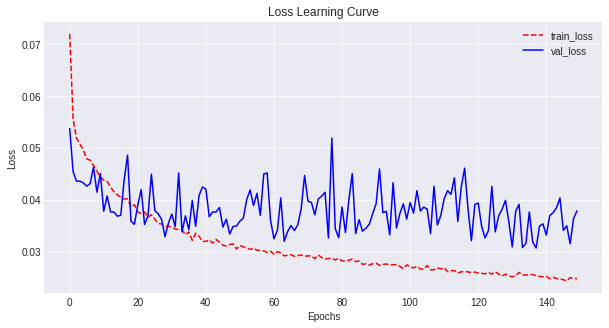

Test  Loss: [0.0344 0.1426]
Kappa List: [0.6079 0.4991 0.5307 0.7124 0.6338 0.7333 0.674 ]
Test Quadratic Cohen Kappa Score (per essay set): 0.6273
Test Quadratic Cohen Kappa Score (all essay set): 0.9702

			 -------- Fold 4 --------
Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_56 (LSTM)               (None, 1, 300)            721200    
_________________________________________________________________
lstm_57 (LSTM)               (None, 64)                93440     
_________________________________________________________________
dropout_28 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 65        
Total params: 814,705
Trainable params: 814,705
Non-trainable params: 0
_________________________________________________________________
Total Trai

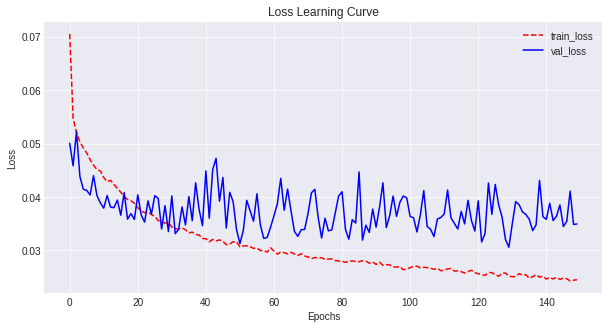

Test  Loss: [0.0313 0.1385]
Kappa List: [0.5803 0.4098 0.5495 0.7581 0.6122 0.7325 0.6329]
Test Quadratic Cohen Kappa Score (per essay set): 0.6107
Test Quadratic Cohen Kappa Score (all essay set): 0.9625

			 -------- Fold 5 --------
Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_58 (LSTM)               (None, 1, 300)            721200    
_________________________________________________________________
lstm_59 (LSTM)               (None, 64)                93440     
_________________________________________________________________
dropout_29 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 65        
Total params: 814,705
Trainable params: 814,705
Non-trainable params: 0
_________________________________________________________________
Total Trai

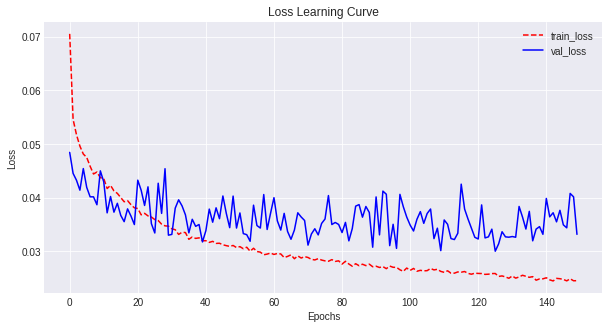

Test  Loss: [0.0336 0.1407]
Kappa List: [0.4489 0.4056 0.5307 0.6718 0.6621 0.727  0.6466]
Test Quadratic Cohen Kappa Score (per essay set): 0.5847
Test Quadratic Cohen Kappa Score (all essay set): 0.9645


			Average Results:
Train Loss: 0.0309
Val   Loss: 0.037
Test  Loss: 0.0866
QCK Score (per essay set): 0.6034
QCK Score (all essay set): 0.9655


In [35]:
cross_val_eval(dim=300, units=64, drate=0.4, batch_size=128, epochs=150, val_size=0.2, verbose=0, callbacks_list=None, isPlot=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Shape of TRAIN X: (11678, 100)
Shape of TEST X:  (1298, 100)
Shape of TRAIN Y: (11678,)
Shape of TEST Y:  (1298,)
Shape of TRAIN SCORE INFO: (11678, 3)
Shape of TEST SCORE INFO:  (1298, 3)
New X Shape: (12976, 1, 100)
New Y Shape: (12976,)
New SCORE INFO Shape: (12976, 3)

			 -------- Fold 1 --------
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 1, 300)            481200    
_________________________________________________________________
lstm_11 (LSTM)               (None, 64)                93440     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 574,705
Trainable params: 574,705
Non-trainable params: 0
_________

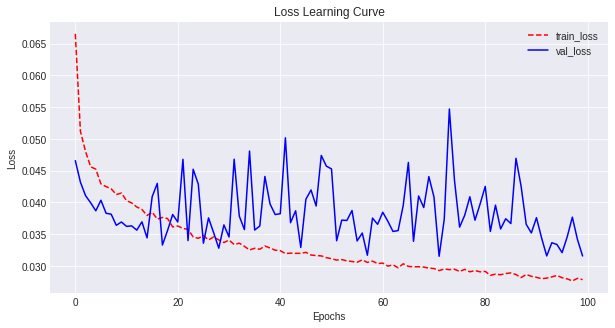

Test  Loss: [0.0311 0.136 ]
Kappa List: [0.4469 0.4043 0.504  0.7127 0.6531 0.7606 0.5696]
Test Quadratic Cohen Kappa Score (per essay set): 0.5788
Test Quadratic Cohen Kappa Score (all essay set): 0.9655

			 -------- Fold 2 --------
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 1, 300)            481200    
_________________________________________________________________
lstm_13 (LSTM)               (None, 64)                93440     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 574,705
Trainable params: 574,705
Non-trainable params: 0
_________________________________________________________________
Total Train

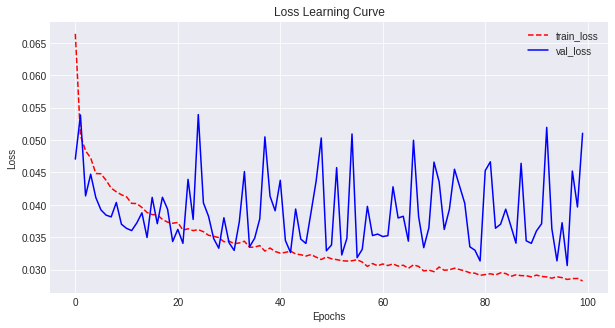

Test  Loss: [0.0462 0.1701]
Kappa List: [0.4595 0.5173 0.5199 0.6945 0.6916 0.6778 0.6076]
Test Quadratic Cohen Kappa Score (per essay set): 0.5955
Test Quadratic Cohen Kappa Score (all essay set): 0.959

			 -------- Fold 3 --------
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 1, 300)            481200    
_________________________________________________________________
lstm_15 (LSTM)               (None, 64)                93440     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 574,705
Trainable params: 574,705
Non-trainable params: 0
_________________________________________________________________
Total Traini

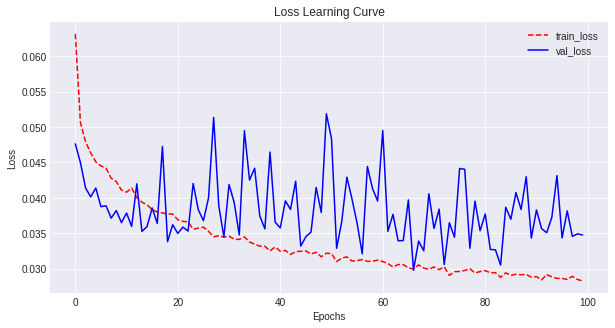

Test  Loss: [0.0325 0.1414]
Kappa List: [0.6535 0.5122 0.5841 0.6933 0.6261 0.727  0.6225]
Test Quadratic Cohen Kappa Score (per essay set): 0.6313
Test Quadratic Cohen Kappa Score (all essay set): 0.9654

			 -------- Fold 4 --------
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 1, 300)            481200    
_________________________________________________________________
lstm_17 (LSTM)               (None, 64)                93440     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 65        
Total params: 574,705
Trainable params: 574,705
Non-trainable params: 0
_________________________________________________________________
Total Trai

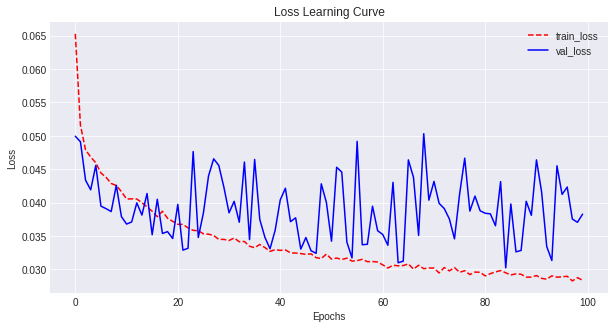

Test  Loss: [0.0345 0.1456]
Kappa List: [0.6925 0.4677 0.5115 0.7473 0.6211 0.7564 0.649 ]
Test Quadratic Cohen Kappa Score (per essay set): 0.6351
Test Quadratic Cohen Kappa Score (all essay set): 0.9666

			 -------- Fold 5 --------
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 1, 300)            481200    
_________________________________________________________________
lstm_19 (LSTM)               (None, 64)                93440     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 574,705
Trainable params: 574,705
Non-trainable params: 0
_________________________________________________________________
Total Trai

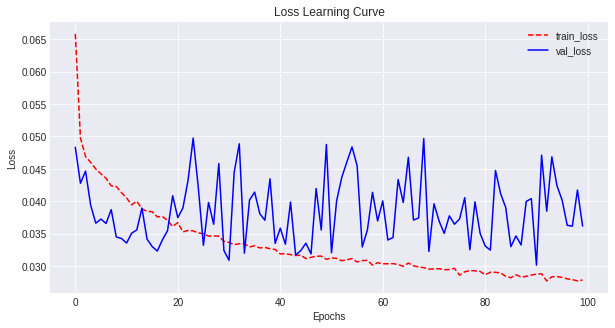

Test  Loss: [0.0367 0.148 ]
Kappa List: [0.5019 0.4928 0.477  0.6416 0.6516 0.7063 0.6315]
Test Quadratic Cohen Kappa Score (per essay set): 0.5861
Test Quadratic Cohen Kappa Score (all essay set): 0.9683


			Average Results:
Train Loss: 0.0335
Val   Loss: 0.0386
Test  Loss: 0.0922
QCK Score (per essay set): 0.6053
QCK Score (all essay set): 0.965


In [26]:
#0.2
cross_val_eval(dim=100, units=64, drate=0.2, batch_size=128, epochs=100, val_size=0.1, verbose=0, callbacks_list=None, isPlot=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Shape of TRAIN X: (11678, 100)
Shape of TEST X:  (1298, 100)
Shape of TRAIN Y: (11678,)
Shape of TEST Y:  (1298,)
Shape of TRAIN SCORE INFO: (11678, 3)
Shape of TEST SCORE INFO:  (1298, 3)
New X Shape: (12976, 1, 100)
New Y Shape: (12976,)
New SCORE INFO Shape: (12976, 3)

			 -------- Fold 1 --------
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 1, 300)            481200    
_________________________________________________________________
lstm_21 (LSTM)               (None, 64)                93440     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 65        
Total params: 574,705
Trainable params: 574,705
Non-trainable params: 0
________

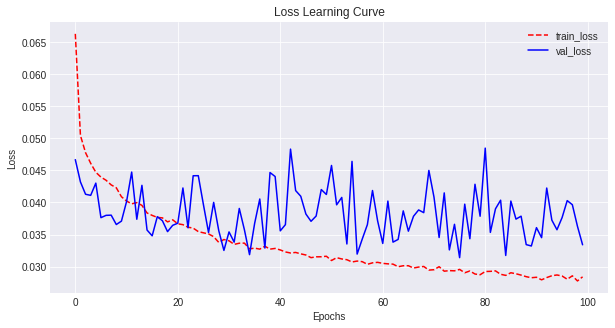

Test  Loss: [0.0334 0.1414]
Kappa List: [0.4237 0.4281 0.4928 0.6957 0.6305 0.7681 0.5931]
Test Quadratic Cohen Kappa Score (per essay set): 0.576
Test Quadratic Cohen Kappa Score (all essay set): 0.965

			 -------- Fold 2 --------
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 1, 300)            481200    
_________________________________________________________________
lstm_23 (LSTM)               (None, 64)                93440     
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 65        
Total params: 574,705
Trainable params: 574,705
Non-trainable params: 0
_________________________________________________________________
Total Traini

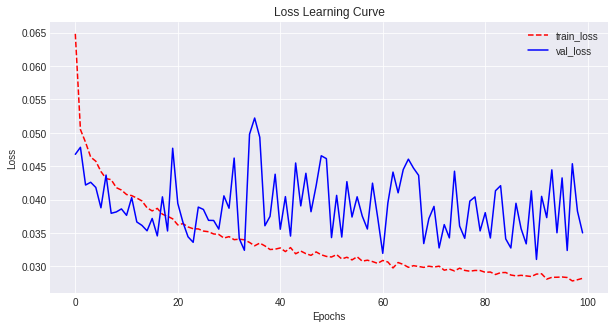

Test  Loss: [0.0317 0.139 ]
Kappa List: [0.5474 0.5106 0.5124 0.6724 0.6972 0.7138 0.6043]
Test Quadratic Cohen Kappa Score (per essay set): 0.6083
Test Quadratic Cohen Kappa Score (all essay set): 0.9597

			 -------- Fold 3 --------
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 1, 300)            481200    
_________________________________________________________________
lstm_25 (LSTM)               (None, 64)                93440     
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 65        
Total params: 574,705
Trainable params: 574,705
Non-trainable params: 0
_________________________________________________________________
Total Trai

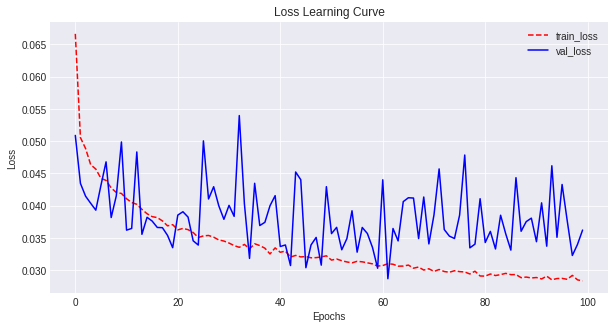

Test  Loss: [0.0336 0.1435]
Kappa List: [0.6479 0.5121 0.5671 0.7153 0.6511 0.7275 0.6118]
Test Quadratic Cohen Kappa Score (per essay set): 0.6332
Test Quadratic Cohen Kappa Score (all essay set): 0.9668

			 -------- Fold 4 --------
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_26 (LSTM)               (None, 1, 300)            481200    
_________________________________________________________________
lstm_27 (LSTM)               (None, 64)                93440     
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 65        
Total params: 574,705
Trainable params: 574,705
Non-trainable params: 0
_________________________________________________________________
Total Trai

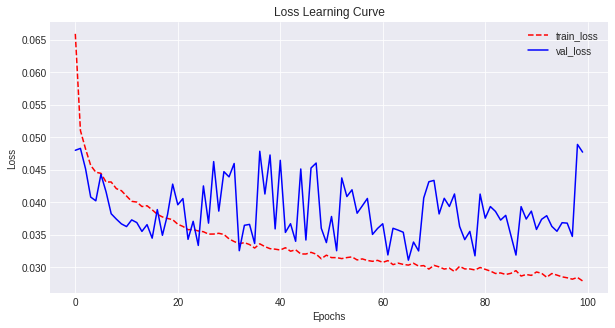

Test  Loss: [0.0451 0.168 ]
Kappa List: [0.6909 0.4473 0.5321 0.6998 0.5836 0.7484 0.6277]
Test Quadratic Cohen Kappa Score (per essay set): 0.6185
Test Quadratic Cohen Kappa Score (all essay set): 0.966

			 -------- Fold 5 --------
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 1, 300)            481200    
_________________________________________________________________
lstm_29 (LSTM)               (None, 64)                93440     
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 65        
Total params: 574,705
Trainable params: 574,705
Non-trainable params: 0
_________________________________________________________________
Total Train

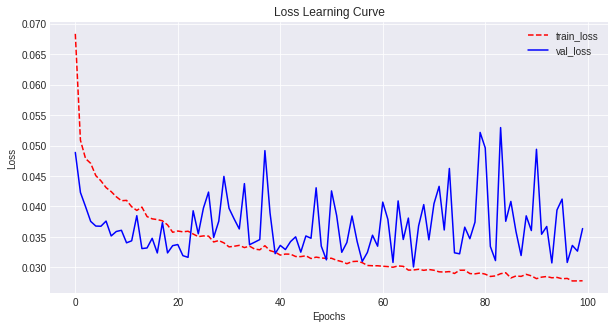

Test  Loss: [0.0387 0.1516]
Kappa List: [0.5365 0.4821 0.4713 0.6747 0.5586 0.7296 0.6275]
Test Quadratic Cohen Kappa Score (per essay set): 0.5829
Test Quadratic Cohen Kappa Score (all essay set): 0.9687


			Average Results:
Train Loss: 0.0335
Val   Loss: 0.0383
Test  Loss: 0.0926
QCK Score (per essay set): 0.6038
QCK Score (all essay set): 0.9652


In [27]:
#0.2
cross_val_eval(dim=100, units=64, drate=0.2, batch_size=128, epochs=100, val_size=0.1, verbose=0, callbacks_list=None, isPlot=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Shape of TRAIN X: (11678, 300)
Shape of TEST X:  (1298, 300)
Shape of TRAIN Y: (11678,)
Shape of TEST Y:  (1298,)
Shape of TRAIN SCORE INFO: (11678, 3)
Shape of TEST SCORE INFO:  (1298, 3)
New X Shape: (12976, 1, 300)
New Y Shape: (12976,)
New SCORE INFO Shape: (12976, 3)

			 -------- Fold 1 --------
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_30 (LSTM)               (None, 1, 300)            721200    
_________________________________________________________________
lstm_31 (LSTM)               (None, 64)                93440     
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 65        
Total params: 814,705
Trainable params: 814,705
Non-trainable params: 0
________

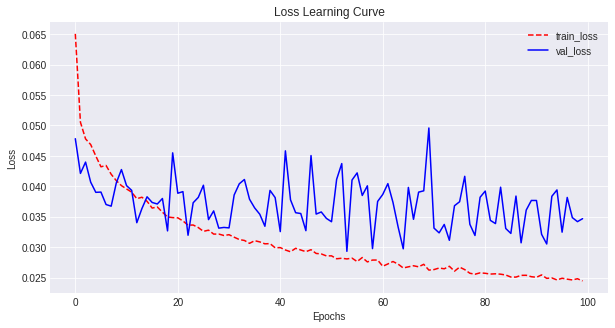

Test  Loss: [0.0328 0.1395]
Kappa List: [0.4927 0.3871 0.4972 0.6834 0.6351 0.7126 0.6528]
Test Quadratic Cohen Kappa Score (per essay set): 0.5801
Test Quadratic Cohen Kappa Score (all essay set): 0.9676

			 -------- Fold 2 --------
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_32 (LSTM)               (None, 1, 300)            721200    
_________________________________________________________________
lstm_33 (LSTM)               (None, 64)                93440     
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 65        
Total params: 814,705
Trainable params: 814,705
Non-trainable params: 0
_________________________________________________________________
Total Trai

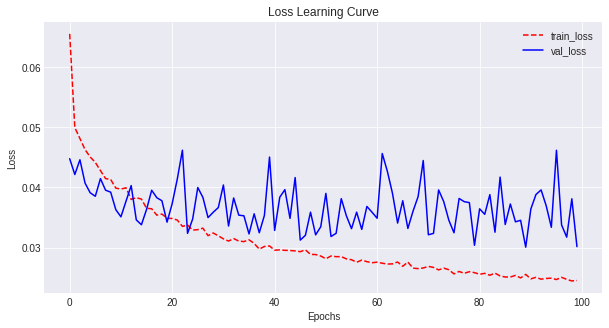

Test  Loss: [0.0258 0.125 ]
Kappa List: [0.4983 0.3136 0.5703 0.723  0.7004 0.7082 0.6794]
Test Quadratic Cohen Kappa Score (per essay set): 0.5991
Test Quadratic Cohen Kappa Score (all essay set): 0.9686

			 -------- Fold 3 --------
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_34 (LSTM)               (None, 1, 300)            721200    
_________________________________________________________________
lstm_35 (LSTM)               (None, 64)                93440     
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 65        
Total params: 814,705
Trainable params: 814,705
Non-trainable params: 0
_________________________________________________________________
Total Trai

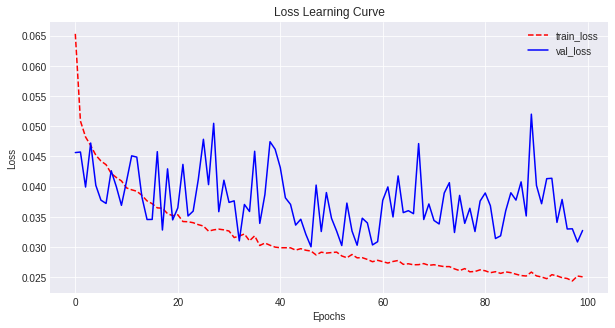

Test  Loss: [0.0298 0.1347]
Kappa List: [0.5709 0.5019 0.5827 0.7455 0.6149 0.7479 0.6737]
Test Quadratic Cohen Kappa Score (per essay set): 0.6339
Test Quadratic Cohen Kappa Score (all essay set): 0.9703

			 -------- Fold 4 --------
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_36 (LSTM)               (None, 1, 300)            721200    
_________________________________________________________________
lstm_37 (LSTM)               (None, 64)                93440     
_________________________________________________________________
dropout_13 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 65        
Total params: 814,705
Trainable params: 814,705
Non-trainable params: 0
_________________________________________________________________
Total Trai

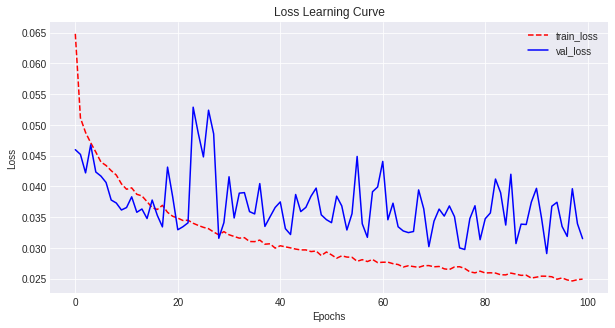

Test  Loss: [0.0283 0.13  ]
Kappa List: [0.6368 0.4396 0.5385 0.7709 0.6437 0.7414 0.6575]
Test Quadratic Cohen Kappa Score (per essay set): 0.6326
Test Quadratic Cohen Kappa Score (all essay set): 0.9652

			 -------- Fold 5 --------
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_38 (LSTM)               (None, 1, 300)            721200    
_________________________________________________________________
lstm_39 (LSTM)               (None, 64)                93440     
_________________________________________________________________
dropout_14 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 65        
Total params: 814,705
Trainable params: 814,705
Non-trainable params: 0
_________________________________________________________________
Total Trai

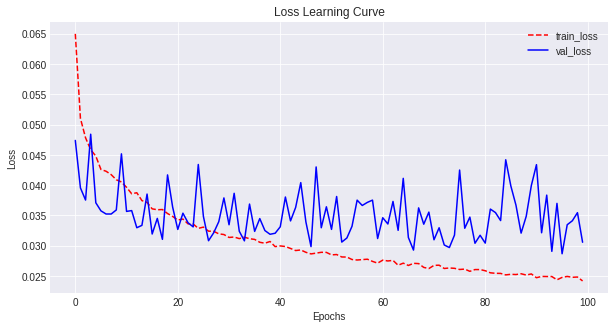

Test  Loss: [0.03   0.1335]
Kappa List: [0.4092 0.3697 0.5697 0.6929 0.6452 0.7513 0.7161]
Test Quadratic Cohen Kappa Score (per essay set): 0.5934
Test Quadratic Cohen Kappa Score (all essay set): 0.9683


			Average Results:
Train Loss: 0.031
Val   Loss: 0.0368
Test  Loss: 0.0809
QCK Score (per essay set): 0.6078
QCK Score (all essay set): 0.968


In [34]:
#0.3
cross_val_eval(dim=300, units=64, drate=0.3, batch_size=128, epochs=100, val_size=0.1, verbose=0, callbacks_list=None, isPlot=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Shape of TRAIN X: (11678, 100)
Shape of TEST X:  (1298, 100)
Shape of TRAIN Y: (11678,)
Shape of TEST Y:  (1298,)
Shape of TRAIN SCORE INFO: (11678, 3)
Shape of TEST SCORE INFO:  (1298, 3)
New X Shape: (12976, 1, 100)
New Y Shape: (12976,)
New SCORE INFO Shape: (12976, 3)

			 -------- Fold 1 --------
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_40 (LSTM)               (None, 1, 300)            481200    
_________________________________________________________________
lstm_41 (LSTM)               (None, 64)                93440     
_________________________________________________________________
dropout_15 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 65        
Total params: 574,705
Trainable params: 574,705
Non-trainable params: 0
________

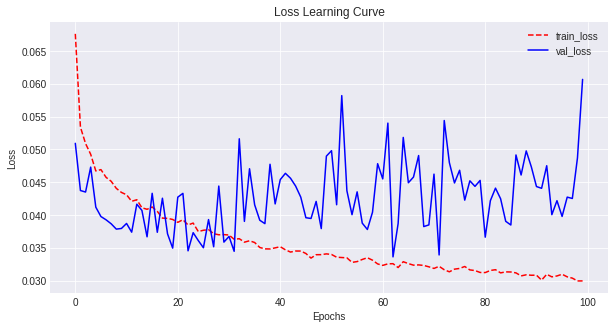

Test  Loss: [0.0585 0.1933]
Kappa List: [0.4315 0.4263 0.4852 0.7003 0.6291 0.735  0.5337]
Test Quadratic Cohen Kappa Score (per essay set): 0.563
Test Quadratic Cohen Kappa Score (all essay set): 0.9609

			 -------- Fold 2 --------
Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_42 (LSTM)               (None, 1, 300)            481200    
_________________________________________________________________
lstm_43 (LSTM)               (None, 64)                93440     
_________________________________________________________________
dropout_16 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 65        
Total params: 574,705
Trainable params: 574,705
Non-trainable params: 0
_________________________________________________________________
Total Train

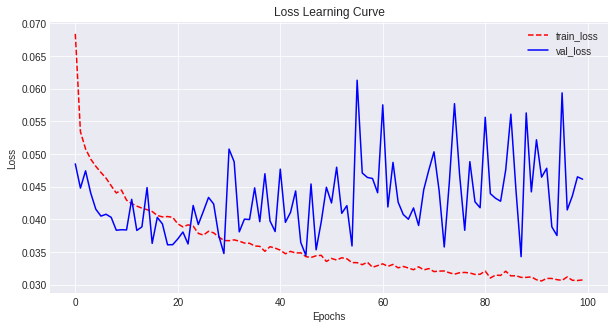

Test  Loss: [0.0411 0.1588]
Kappa List: [0.5214 0.4527 0.5192 0.6676 0.6831 0.6639 0.5856]
Test Quadratic Cohen Kappa Score (per essay set): 0.5848
Test Quadratic Cohen Kappa Score (all essay set): 0.9576

			 -------- Fold 3 --------
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_44 (LSTM)               (None, 1, 300)            481200    
_________________________________________________________________
lstm_45 (LSTM)               (None, 64)                93440     
_________________________________________________________________
dropout_17 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 65        
Total params: 574,705
Trainable params: 574,705
Non-trainable params: 0
_________________________________________________________________
Total Trai

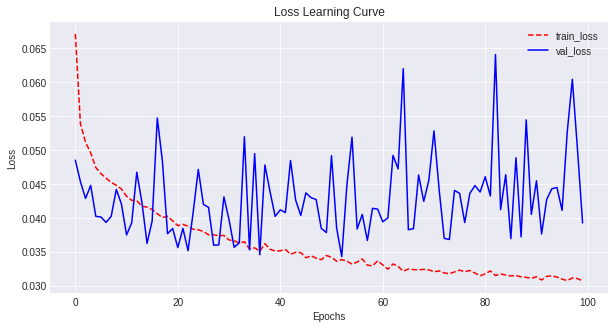

Test  Loss: [0.0366 0.1519]
Kappa List: [0.6597 0.4714 0.5609 0.6782 0.6139 0.7014 0.5813]
Test Quadratic Cohen Kappa Score (per essay set): 0.6095
Test Quadratic Cohen Kappa Score (all essay set): 0.963

			 -------- Fold 4 --------
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_46 (LSTM)               (None, 1, 300)            481200    
_________________________________________________________________
lstm_47 (LSTM)               (None, 64)                93440     
_________________________________________________________________
dropout_18 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 65        
Total params: 574,705
Trainable params: 574,705
Non-trainable params: 0
_________________________________________________________________
Total Train

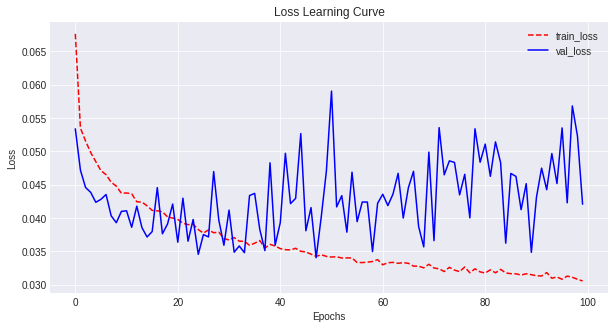

Test  Loss: [0.0383 0.154 ]
Kappa List: [0.6572 0.4357 0.5031 0.7007 0.6171 0.721  0.6407]
Test Quadratic Cohen Kappa Score (per essay set): 0.6108
Test Quadratic Cohen Kappa Score (all essay set): 0.9623

			 -------- Fold 5 --------
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_48 (LSTM)               (None, 1, 300)            481200    
_________________________________________________________________
lstm_49 (LSTM)               (None, 64)                93440     
_________________________________________________________________
dropout_19 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 65        
Total params: 574,705
Trainable params: 574,705
Non-trainable params: 0
_________________________________________________________________
Total Trai

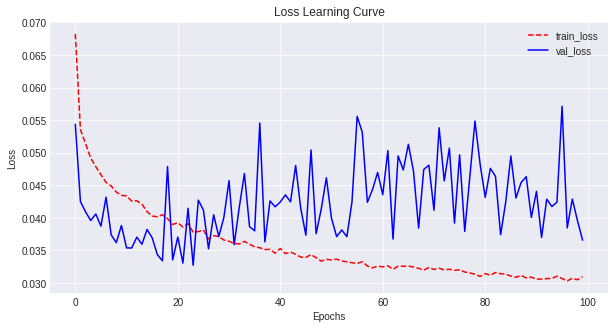

Test  Loss: [0.0376 0.149 ]
Kappa List: [0.4597 0.4586 0.4813 0.6432 0.6269 0.7021 0.6355]
Test Quadratic Cohen Kappa Score (per essay set): 0.5725
Test Quadratic Cohen Kappa Score (all essay set): 0.9665


			Average Results:
Train Loss: 0.036
Val   Loss: 0.0428
Test  Loss: 0.1019
QCK Score (per essay set): 0.5881
QCK Score (all essay set): 0.9621


In [35]:
#0.3
cross_val_eval(dim=100, units=64, drate=0.3, batch_size=128, epochs=100, val_size=0.1, verbose=0, callbacks_list=None, isPlot=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Shape of TRAIN X: (11678, 100)
Shape of TEST X:  (1298, 100)
Shape of TRAIN Y: (11678,)
Shape of TEST Y:  (1298,)
Shape of TRAIN SCORE INFO: (11678, 3)
Shape of TEST SCORE INFO:  (1298, 3)
New X Shape: (12976, 1, 100)
New Y Shape: (12976,)
New SCORE INFO Shape: (12976, 3)

			 -------- Fold 1 --------
Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_50 (LSTM)               (None, 1, 128)            117248    
_________________________________________________________________
lstm_51 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dropout_20 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 65        
Total params: 166,721
Trainable params: 166,721
Non-trainable params: 0
________

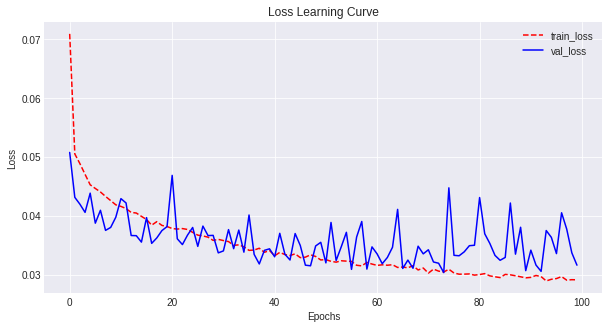

Test  Loss: [0.0309 0.1359]
Kappa List: [0.4207 0.3624 0.455  0.6819 0.6501 0.7401 0.5276]
Test Quadratic Cohen Kappa Score (per essay set): 0.5482
Test Quadratic Cohen Kappa Score (all essay set): 0.965

			 -------- Fold 2 --------
Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_52 (LSTM)               (None, 1, 128)            117248    
_________________________________________________________________
lstm_53 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dropout_21 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 65        
Total params: 166,721
Trainable params: 166,721
Non-trainable params: 0
_________________________________________________________________
Total Train

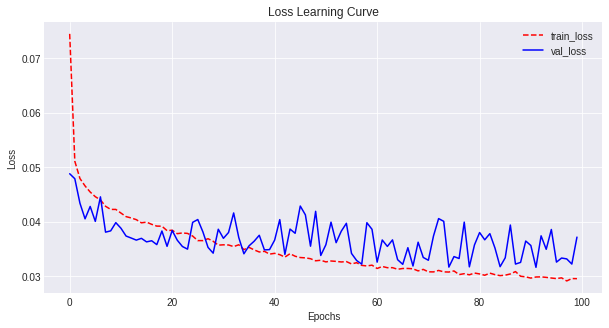

Test  Loss: [0.0332 0.1432]
Kappa List: [0.5733 0.4808 0.4883 0.7014 0.6599 0.6934 0.6155]
Test Quadratic Cohen Kappa Score (per essay set): 0.6018
Test Quadratic Cohen Kappa Score (all essay set): 0.958

			 -------- Fold 3 --------
Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_54 (LSTM)               (None, 1, 128)            117248    
_________________________________________________________________
lstm_55 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dropout_22 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 65        
Total params: 166,721
Trainable params: 166,721
Non-trainable params: 0
_________________________________________________________________
Total Train

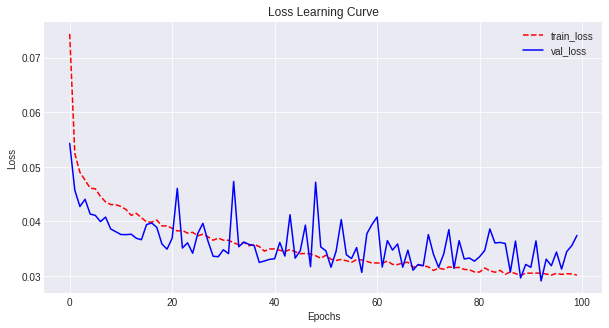

Test  Loss: [0.0344 0.146 ]
Kappa List: [0.6395 0.4986 0.5233 0.7066 0.6224 0.724  0.5999]
Test Quadratic Cohen Kappa Score (per essay set): 0.6163
Test Quadratic Cohen Kappa Score (all essay set): 0.9619

			 -------- Fold 4 --------
Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_56 (LSTM)               (None, 1, 128)            117248    
_________________________________________________________________
lstm_57 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dropout_23 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 65        
Total params: 166,721
Trainable params: 166,721
Non-trainable params: 0
_________________________________________________________________
Total Trai

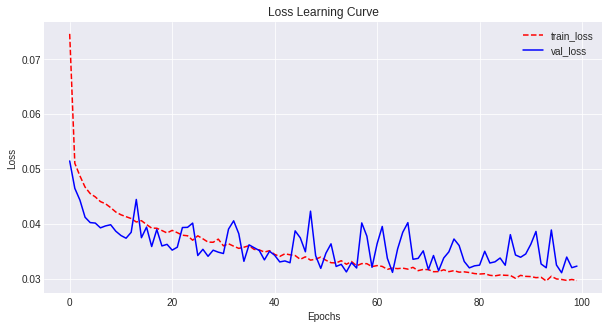

Test  Loss: [0.0296 0.1342]
Kappa List: [0.6184 0.3847 0.5206 0.6923 0.5729 0.7237 0.6279]
Test Quadratic Cohen Kappa Score (per essay set): 0.5915
Test Quadratic Cohen Kappa Score (all essay set): 0.9637

			 -------- Fold 5 --------
Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_58 (LSTM)               (None, 1, 128)            117248    
_________________________________________________________________
lstm_59 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dropout_24 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 65        
Total params: 166,721
Trainable params: 166,721
Non-trainable params: 0
_________________________________________________________________
Total Trai

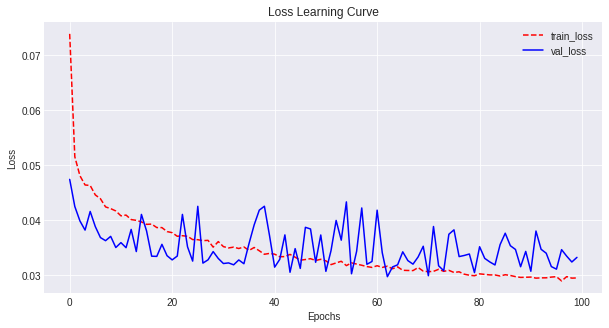

Test  Loss: [0.0336 0.1422]
Kappa List: [0.4249 0.5043 0.5193 0.6256 0.5598 0.7042 0.648 ]
Test Quadratic Cohen Kappa Score (per essay set): 0.5695
Test Quadratic Cohen Kappa Score (all essay set): 0.9677


			Average Results:
Train Loss: 0.0349
Val   Loss: 0.036
Test  Loss: 0.0863
QCK Score (per essay set): 0.5855
QCK Score (all essay set): 0.9633


In [54]:
#0.2
cross_val_eval(dim=100, units=64, drate=0.2, batch_size=128, epochs=100, val_size=0.1, verbose=0, callbacks_list=None, isPlot=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Shape of TRAIN X: (11678, 100)
Shape of TEST X:  (1298, 100)
Shape of TRAIN Y: (11678,)
Shape of TEST Y:  (1298,)
Shape of TRAIN SCORE INFO: (11678, 3)
Shape of TEST SCORE INFO:  (1298, 3)
New X Shape: (12976, 1, 100)
New Y Shape: (12976,)
New SCORE INFO Shape: (12976, 3)

			 -------- Fold 1 --------
Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_60 (LSTM)               (None, 1, 128)            117248    
_________________________________________________________________
lstm_61 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dropout_25 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 65        
Total params: 166,721
Trainable params: 166,721
Non-trainable params: 0
________

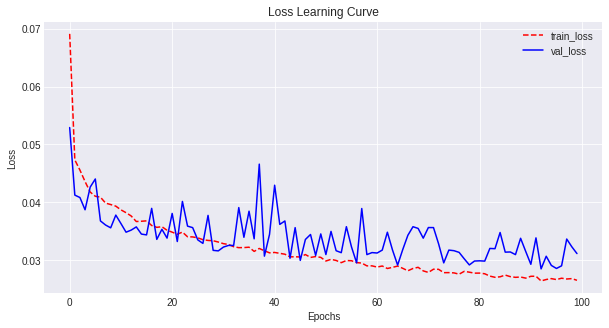

Test  Loss: [0.0307 0.136 ]
Kappa List: [0.476  0.3042 0.4642 0.6721 0.672  0.7639 0.6471]
Test Quadratic Cohen Kappa Score (per essay set): 0.5713
Test Quadratic Cohen Kappa Score (all essay set): 0.9693

			 -------- Fold 2 --------
Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_62 (LSTM)               (None, 1, 128)            117248    
_________________________________________________________________
lstm_63 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dropout_26 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 65        
Total params: 166,721
Trainable params: 166,721
Non-trainable params: 0
_________________________________________________________________
Total Trai

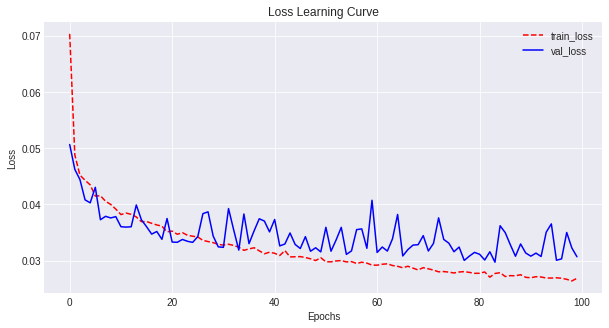

Test  Loss: [0.0269 0.1275]
Kappa List: [0.5298 0.4857 0.4799 0.6875 0.6856 0.7001 0.6502]
Test Quadratic Cohen Kappa Score (per essay set): 0.6027
Test Quadratic Cohen Kappa Score (all essay set): 0.9614

			 -------- Fold 3 --------
Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_64 (LSTM)               (None, 1, 128)            117248    
_________________________________________________________________
lstm_65 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dropout_27 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 65        
Total params: 166,721
Trainable params: 166,721
Non-trainable params: 0
_________________________________________________________________
Total Trai

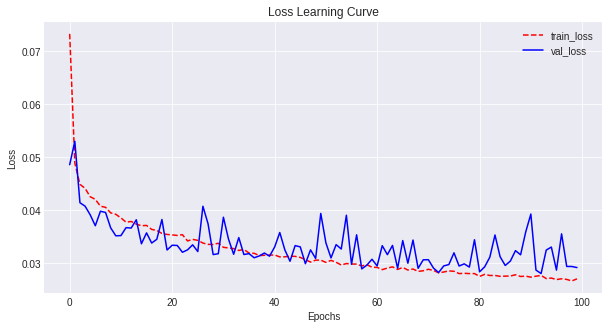

Test  Loss: [0.0274 0.1289]
Kappa List: [0.6531 0.4762 0.5606 0.6903 0.6228 0.7055 0.628 ]
Test Quadratic Cohen Kappa Score (per essay set): 0.6195
Test Quadratic Cohen Kappa Score (all essay set): 0.9708

			 -------- Fold 4 --------
Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_66 (LSTM)               (None, 1, 128)            117248    
_________________________________________________________________
lstm_67 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dropout_28 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 65        
Total params: 166,721
Trainable params: 166,721
Non-trainable params: 0
_________________________________________________________________
Total Trai

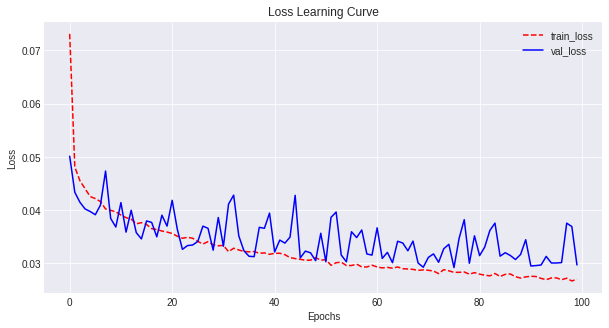

Test  Loss: [0.0273 0.1291]
Kappa List: [0.6789 0.3738 0.5174 0.7403 0.6328 0.7536 0.6185]
Test Quadratic Cohen Kappa Score (per essay set): 0.6165
Test Quadratic Cohen Kappa Score (all essay set): 0.9681

			 -------- Fold 5 --------
Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_68 (LSTM)               (None, 1, 128)            117248    
_________________________________________________________________
lstm_69 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dropout_29 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 65        
Total params: 166,721
Trainable params: 166,721
Non-trainable params: 0
_________________________________________________________________
Total Trai

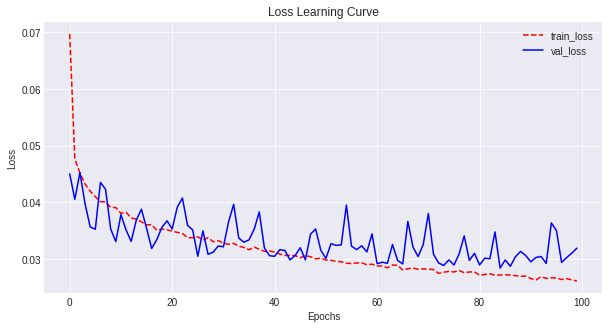

Test  Loss: [0.0323 0.1387]
Kappa List: [0.4678 0.5348 0.4597 0.6392 0.6049 0.713  0.6826]
Test Quadratic Cohen Kappa Score (per essay set): 0.586
Test Quadratic Cohen Kappa Score (all essay set): 0.97


			Average Results:
Train Loss: 0.032
Val   Loss: 0.034
Test  Loss: 0.0805
QCK Score (per essay set): 0.5992
QCK Score (all essay set): 0.9679


In [55]:
#0.1
cross_val_eval(dim=100, units=64, drate=0.1, batch_size=128, epochs=100, val_size=0.1, verbose=0, callbacks_list=None, isPlot=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Shape of TRAIN X: (11678, 300)
Shape of TEST X:  (1298, 300)
Shape of TRAIN Y: (11678,)
Shape of TEST Y:  (1298,)
Shape of TRAIN SCORE INFO: (11678, 3)
Shape of TEST SCORE INFO:  (1298, 3)
New X Shape: (12976, 1, 300)
New Y Shape: (12976,)
New SCORE INFO Shape: (12976, 3)

			 -------- Fold 1 --------
Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_70 (LSTM)               (None, 1, 128)            219648    
_________________________________________________________________
lstm_71 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dropout_30 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 65        
Total params: 269,121
Trainable params: 269,121
Non-trainable params: 0
________

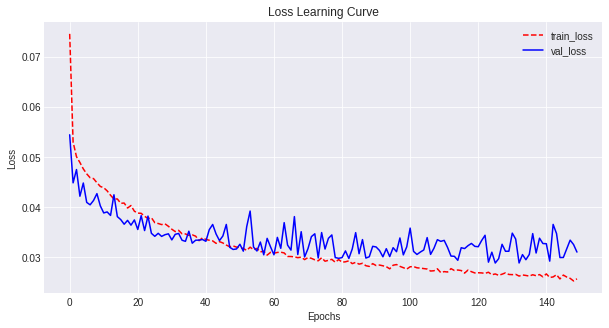

Test  Loss: [0.0311 0.1376]
Kappa List: [0.4596 0.4486 0.4524 0.637  0.6097 0.7445 0.6638]
Test Quadratic Cohen Kappa Score (per essay set): 0.5737
Test Quadratic Cohen Kappa Score (all essay set): 0.9681

			 -------- Fold 2 --------
Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_72 (LSTM)               (None, 1, 128)            219648    
_________________________________________________________________
lstm_73 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dropout_31 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 65        
Total params: 269,121
Trainable params: 269,121
Non-trainable params: 0
_________________________________________________________________
Total Trai

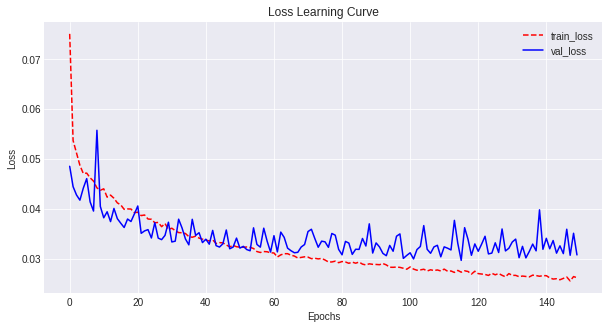

Test  Loss: [0.028  0.1306]
Kappa List: [0.4734 0.5124 0.5162 0.6963 0.6875 0.7155 0.6559]
Test Quadratic Cohen Kappa Score (per essay set): 0.6082
Test Quadratic Cohen Kappa Score (all essay set): 0.9688

			 -------- Fold 3 --------
Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_74 (LSTM)               (None, 1, 128)            219648    
_________________________________________________________________
lstm_75 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dropout_32 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 65        
Total params: 269,121
Trainable params: 269,121
Non-trainable params: 0
_________________________________________________________________
Total Trai

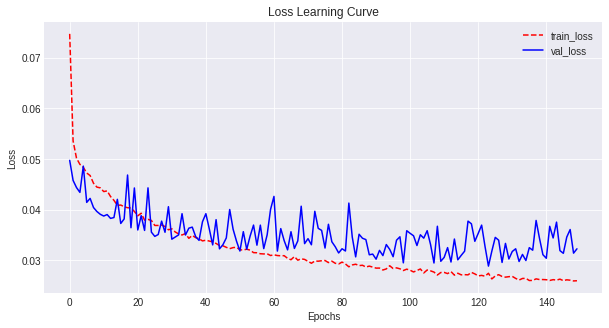

Test  Loss: [0.0296 0.1344]
Kappa List: [0.5579 0.4878 0.5317 0.718  0.5608 0.7394 0.6329]
Test Quadratic Cohen Kappa Score (per essay set): 0.6041
Test Quadratic Cohen Kappa Score (all essay set): 0.971

			 -------- Fold 4 --------
Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_76 (LSTM)               (None, 1, 128)            219648    
_________________________________________________________________
lstm_77 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dropout_33 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 65        
Total params: 269,121
Trainable params: 269,121
Non-trainable params: 0
_________________________________________________________________
Total Train

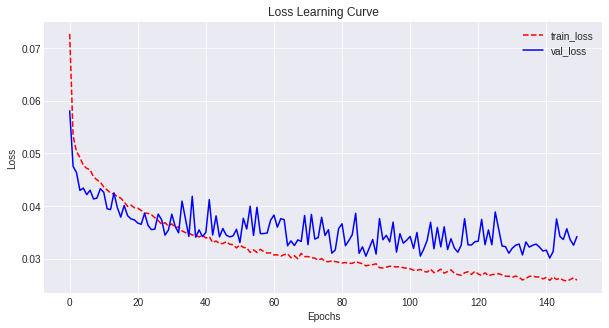

Test  Loss: [0.0309 0.1362]
Kappa List: [0.7146 0.431  0.4931 0.7254 0.585  0.7359 0.6507]
Test Quadratic Cohen Kappa Score (per essay set): 0.6194
Test Quadratic Cohen Kappa Score (all essay set): 0.9665

			 -------- Fold 5 --------
Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_78 (LSTM)               (None, 1, 128)            219648    
_________________________________________________________________
lstm_79 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dropout_34 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 65        
Total params: 269,121
Trainable params: 269,121
Non-trainable params: 0
_________________________________________________________________
Total Trai

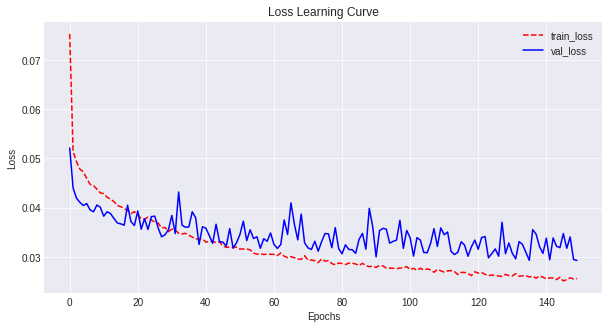

Test  Loss: [0.0296 0.1347]
Kappa List: [0.4395 0.411  0.5292 0.6708 0.6333 0.7113 0.6857]
Test Quadratic Cohen Kappa Score (per essay set): 0.583
Test Quadratic Cohen Kappa Score (all essay set): 0.9693


			Average Results:
Train Loss: 0.0319
Val   Loss: 0.0347
Test  Loss: 0.0823
QCK Score (per essay set): 0.5976
QCK Score (all essay set): 0.9687


In [56]:
#0.4
cross_val_eval(dim=300, units=64, drate=0.4, batch_size=128, epochs=150, val_size=0.2, verbose=0, callbacks_list=None, isPlot=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Shape of TRAIN X: (11678, 300)
Shape of TEST X:  (1298, 300)
Shape of TRAIN Y: (11678,)
Shape of TEST Y:  (1298,)
Shape of TRAIN SCORE INFO: (11678, 3)
Shape of TEST SCORE INFO:  (1298, 3)
New X Shape: (12976, 1, 300)
New Y Shape: (12976,)
New SCORE INFO Shape: (12976, 3)

			 -------- Fold 1 --------
Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_80 (LSTM)               (None, 1, 128)            219648    
_________________________________________________________________
lstm_81 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dropout_35 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 65        
Total params: 269,121
Trainable params: 269,121
Non-trainable params: 0
________

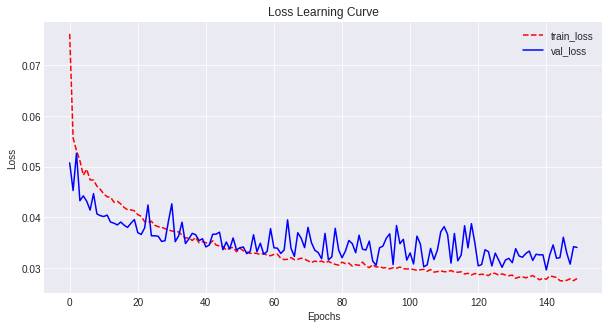

Test  Loss: [0.0337 0.1432]
Kappa List: [0.4907 0.4165 0.4743 0.6601 0.6337 0.7194 0.6285]
Test Quadratic Cohen Kappa Score (per essay set): 0.5747
Test Quadratic Cohen Kappa Score (all essay set): 0.9635

			 -------- Fold 2 --------
Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_82 (LSTM)               (None, 1, 128)            219648    
_________________________________________________________________
lstm_83 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dropout_36 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 65        
Total params: 269,121
Trainable params: 269,121
Non-trainable params: 0
_________________________________________________________________
Total Trai

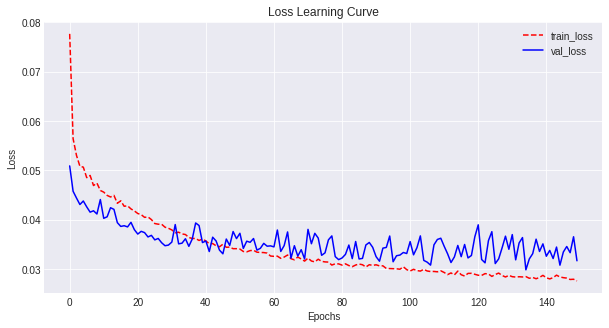

Test  Loss: [0.0291 0.1331]
Kappa List: [0.4543 0.4824 0.5038 0.6798 0.6795 0.6666 0.6642]
Test Quadratic Cohen Kappa Score (per essay set): 0.5901
Test Quadratic Cohen Kappa Score (all essay set): 0.966

			 -------- Fold 3 --------
Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_84 (LSTM)               (None, 1, 128)            219648    
_________________________________________________________________
lstm_85 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dropout_37 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 65        
Total params: 269,121
Trainable params: 269,121
Non-trainable params: 0
_________________________________________________________________
Total Train

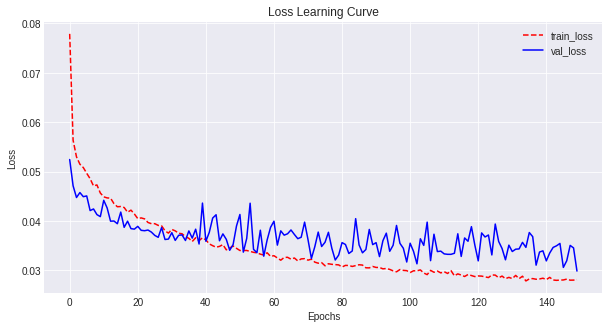

Test  Loss: [0.0277 0.1294]
Kappa List: [0.5281 0.4855 0.5387 0.7347 0.5781 0.737  0.6359]
Test Quadratic Cohen Kappa Score (per essay set): 0.6054
Test Quadratic Cohen Kappa Score (all essay set): 0.9666

			 -------- Fold 4 --------
Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_86 (LSTM)               (None, 1, 128)            219648    
_________________________________________________________________
lstm_87 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dropout_38 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 65        
Total params: 269,121
Trainable params: 269,121
Non-trainable params: 0
_________________________________________________________________
Total Trai

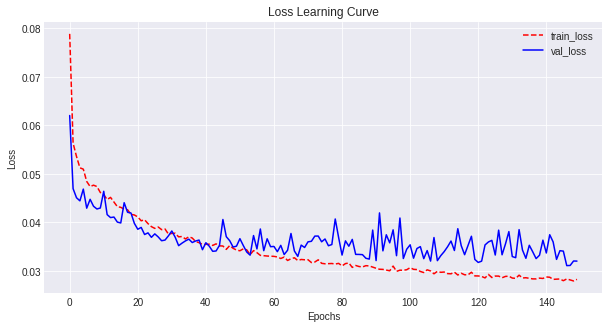

Test  Loss: [0.0287 0.1321]
Kappa List: [0.5846 0.4114 0.5219 0.7369 0.5756 0.7272 0.6353]
Test Quadratic Cohen Kappa Score (per essay set): 0.599
Test Quadratic Cohen Kappa Score (all essay set): 0.9701

			 -------- Fold 5 --------
Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_88 (LSTM)               (None, 1, 128)            219648    
_________________________________________________________________
lstm_89 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dropout_39 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_46 (Dense)             (None, 1)                 65        
Total params: 269,121
Trainable params: 269,121
Non-trainable params: 0
_________________________________________________________________
Total Train

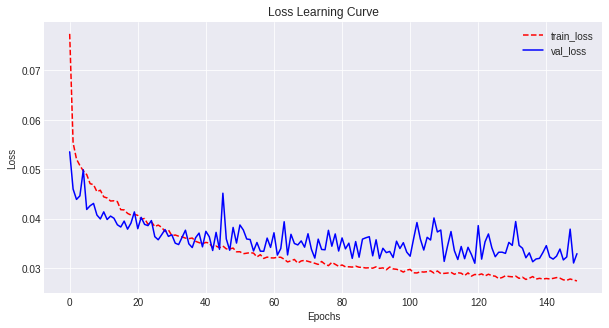

Test  Loss: [0.0328 0.1406]
Kappa List: [0.4419 0.4417 0.4656 0.6358 0.6246 0.6993 0.655 ]
Test Quadratic Cohen Kappa Score (per essay set): 0.5663
Test Quadratic Cohen Kappa Score (all essay set): 0.9681


			Average Results:
Train Loss: 0.0338
Val   Loss: 0.036
Test  Loss: 0.083
QCK Score (per essay set): 0.5871
QCK Score (all essay set): 0.9669


In [57]:
#0.5
cross_val_eval(dim=300, units=64, drate=0.5, batch_size=128, epochs=150, val_size=0.2, verbose=0, callbacks_list=None, isPlot=True)